# Fuel Efficiency Prediction

## The Preparations

### Installing the Libraries

These are all already installed on Google Colab by default so install only if running elsewhere (and ***not already installed***):

In [ ]:
!pip install --upgrade pandas numpy scikit-learn tensorflow xgboost scipy matplotlib seaborn

Install these if running on Google Colab or ***not already installed***:

In [ ]:
!pip install --upgrade machine-learning-datasets
!pip install git+https://github.com/tensorflow/docs
!pip install --upgrade rulefit shap
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

### Loading the Libraries

In [1]:
import math
import os
import machine_learning_datasets as mldatasets
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics, tree
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import xgboost as xgb
from rulefit import RuleFit
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from alepython import ale_plot

In [2]:
print(tf.__version__)

2.2.1


### Understanding and Preparing the Data

In [3]:
fueleconomy_df = mldatasets.load("vehicle-fueleconomy", prepare=True)

https://www.fueleconomy.gov/feg/epadata/vehicles.csv.zip downloaded to /Users/smasis/Documents/OTHER/InterpretableMLBook/programming/Chapter5/data/vehicles.csv.zip
/Users/smasis/Documents/OTHER/InterpretableMLBook/programming/Chapter5/data/vehicles.csv.zip uncompressed to /Users/smasis/Documents/OTHER/InterpretableMLBook/programming/Chapter5/data/vehicles.csv
1 dataset files found in /Users/smasis/Documents/OTHER/InterpretableMLBook/programming/Chapter5/data/vehicles.csv folder
parsing /Users/smasis/Documents/OTHER/InterpretableMLBook/programming/Chapter5/data/vehicles.csv/vehicles.csv


In [4]:
fueleconomy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43317 entries, 0 to 43316
Data columns (total 84 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   make                                       43317 non-null  object 
 1   model                                      43317 non-null  object 
 2   year                                       43317 non-null  int16  
 3   cylinders                                  43317 non-null  float32
 4   displ                                      43317 non-null  float32
 5   phevBlended                                43317 non-null  bool   
 6   co2TailpipeGpm                             43317 non-null  float32
 7   co2                                        43317 non-null  int16  
 8   ghgScore                                   43317 non-null  int16  
 9   pv4                                        43317 non-null  int16  
 10  lv4                   

#### Data Preparation

In [5]:
rand = 9
y = fueleconomy_df['comb08']
X = fueleconomy_df.drop(['comb08','make','model'], axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y,\
                                    test_size=0.15, random_state=rand)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,\
                                    test_size=0.2, random_state=rand)

#### Modeling and Performance Evaluation for Deep Neural Network

In [6]:
os.environ['PYTHONHASHSEED']=str(rand)
tf.random.set_seed(rand)
np.random.seed(rand)

In [29]:
fitted_nn_model = tf.keras.Sequential([
    tf.keras.Input(shape=[len(X_train.keys())]),
    tf.keras.layers.experimental.preprocessing.Normalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
  ])
fitted_nn_model.compile(loss='mean_squared_error',\
                optimizer=tf.keras.optimizers.Adam(lr = 0.0005),\
                metrics=['mse'])
fitted_nn_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 81)                163       
_________________________________________________________________
dense_18 (Dense)             (None, 64)                5248      
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 9,636
Trainable params: 9,473
Non-trainable params: 163
_________________________________________________________________


In [30]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,\
                                      patience=200, min_delta=0.0005,\
                                      restore_best_weights=True)
nn_history = fitted_nn_model.fit(\
                X_train.astype(float), y_train.astype(float), epochs=3000, batch_size=128,\
                validation_data=(X_val.values.astype(float), y_val.values.astype(float)), verbose=1,\
                                 callbacks=[es])

Epoch 1/3000
231/231 [==============================] - 1s 2ms/step - loss: 162.6950 - mse: 162.6950 - val_loss: 8.8590 - val_mse: 8.8590
Epoch 2/3000
231/231 [==============================] - 0s 957us/step - loss: 7.6216 - mse: 7.6216 - val_loss: 6.9158 - val_mse: 6.9158
Epoch 3/3000
231/231 [==============================] - 0s 931us/step - loss: 6.4946 - mse: 6.4946 - val_loss: 8.0765 - val_mse: 8.0765
Epoch 4/3000
231/231 [==============================] - 0s 980us/step - loss: 6.1028 - mse: 6.1028 - val_loss: 5.9096 - val_mse: 5.9096
Epoch 5/3000
231/231 [==============================] - 0s 953us/step - loss: 5.5881 - mse: 5.5881 - val_loss: 5.6222 - val_mse: 5.6222
Epoch 6/3000
231/231 [==============================] - 0s 941us/step - loss: 4.9924 - mse: 4.9924 - val_loss: 5.4326 - val_mse: 5.4326
Epoch 7/3000
231/231 [==============================] - 0s 934us/step - loss: 4.5861 - mse: 4.5861 - val_loss: 4.6052 - val_mse: 4.6052
Epoch 8/3000
231/231 [========================

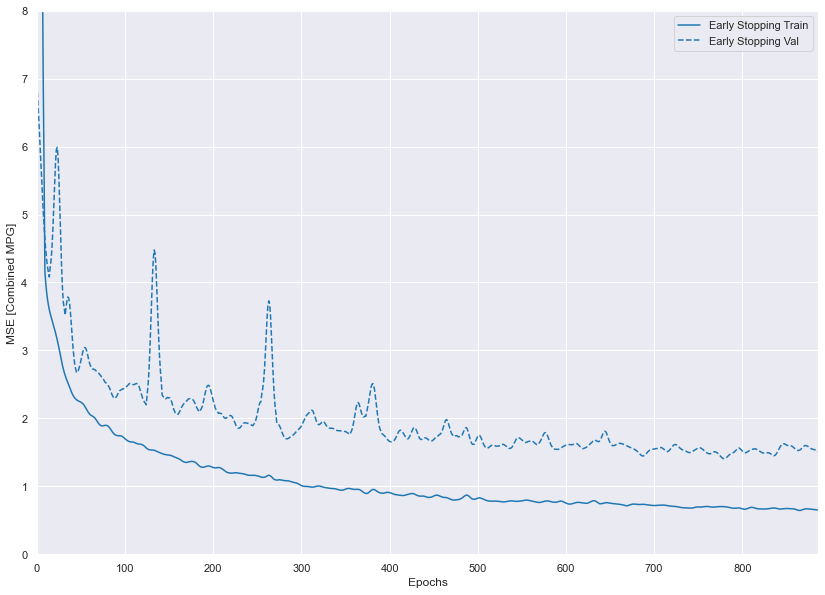

In [31]:
nn_plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
nn_plotter.plot({'Early Stopping': nn_history}, metric = "mse")
plt.rc("figure", figsize=(14, 10))
plt.rcParams.update({'font.size': 14})
plt.ylabel('MSE [Combined MPG]')
plt.ylim([0, 8])
plt.show()

In [22]:
y_train_nn_pred = fitted_nn_model(X_train.astype(float))
y_test_nn_pred = fitted_nn_model.predict(X_test.astype(float))
RMSE_nn_train = metrics.mean_squared_error(y_train,\
                                        y_train_nn_pred, squared=False)
RMSE_nn_test = metrics.mean_squared_error(y_test,\
                                        y_test_nn_pred, squared=False)
R2_nn_test = metrics.r2_score(y_test, y_test_nn_pred)
print('RMSE_train: %.4f\tRMSE_test: %.4f\tr2: %.4f' %\
                    (RMSE_nn_train, RMSE_nn_test, R2_nn_test))

RMSE_train: 0.7012	RMSE_test: 0.7878	r2: 0.9907


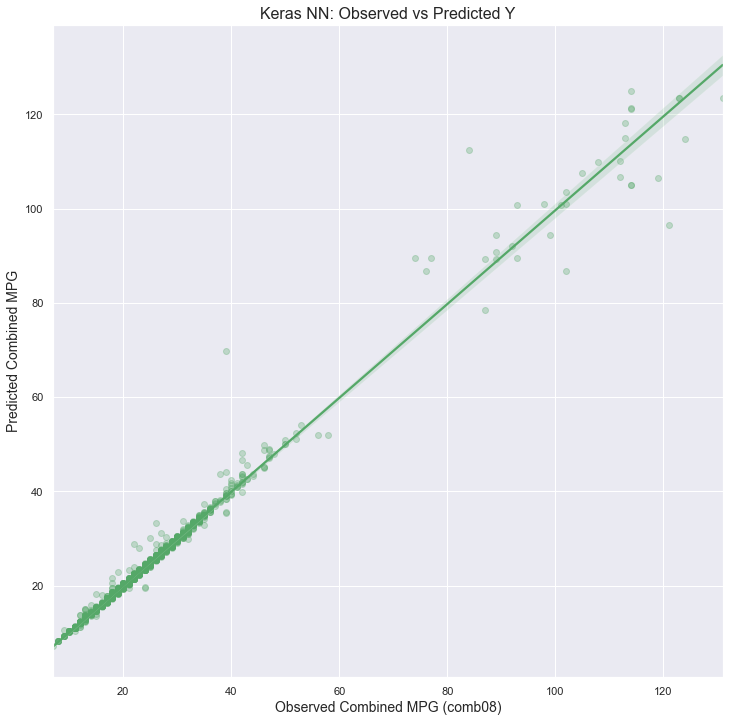

In [33]:
sns.set()
plt.figure(figsize = (12,12))
plt.title('Keras NN: Observed vs Predicted Y', fontsize=16)
plt.ylabel('Predicted Combined MPG', fontsize=14)
sns.regplot(x=y_test, y=y_test_nn_pred, color="g",\
            scatter_kws={'alpha':0.3})
plt.xlabel('Observed Combined MPG (comb08)', fontsize=14)
plt.show() 

#### Modeling and Performance Evaluation for XGBoost

In [34]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [35]:
fitted_xgb_model = xgb.XGBRegressor(max_depth=7, learning_rate=0.6,\
                    n_jobs=4, objective='reg:squarederror',\
                    random_state=rand, n_estimators=50).\
                    fit(X_train, y_train,\
                    eval_set=[(X_train, y_train),(X_val, y_val)],\
                    eval_metric='rmse')

[0]	validation_0-rmse:8.92546	validation_1-rmse:8.94999
[1]	validation_0-rmse:3.67394	validation_1-rmse:3.76829
[2]	validation_0-rmse:1.59030	validation_1-rmse:1.83799
[3]	validation_0-rmse:0.80937	validation_1-rmse:1.25433
[4]	validation_0-rmse:0.54663	validation_1-rmse:1.09026
[5]	validation_0-rmse:0.45794	validation_1-rmse:1.05560
[6]	validation_0-rmse:0.42756	validation_1-rmse:1.06145
[7]	validation_0-rmse:0.40812	validation_1-rmse:1.06841
[8]	validation_0-rmse:0.39150	validation_1-rmse:1.06563
[9]	validation_0-rmse:0.36141	validation_1-rmse:1.06625
[10]	validation_0-rmse:0.35414	validation_1-rmse:1.06407
[11]	validation_0-rmse:0.34884	validation_1-rmse:1.07092
[12]	validation_0-rmse:0.33999	validation_1-rmse:1.07293
[13]	validation_0-rmse:0.32791	validation_1-rmse:1.07193
[14]	validation_0-rmse:0.32221	validation_1-rmse:1.07020
[15]	validation_0-rmse:0.32013	validation_1-rmse:1.06860
[16]	validation_0-rmse:0.31757	validation_1-rmse:1.06854
[17]	validation_0-rmse:0.31505	validation

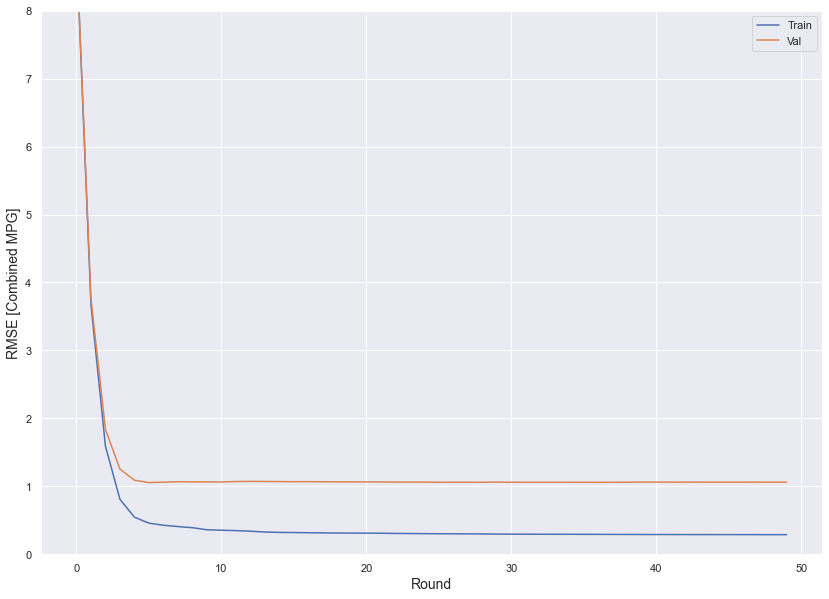

In [37]:
plt.figure(figsize=(14, 10))
plt.rcParams.update({'font.size': 14})
plt.plot(fitted_xgb_model.evals_result()['validation_0']['rmse'])
plt.plot(fitted_xgb_model.evals_result()['validation_1']['rmse'])
plt.ylabel('RMSE [Combined MPG]', fontsize=14)
plt.ylim([0, 8])
plt.xlabel('Round', fontsize=14)
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [69]:
y_train_xgb_pred = fitted_xgb_model.predict(X_train)
y_test_xgb_pred = fitted_xgb_model.predict(X_test)
RMSE_xgb_train = math.sqrt(\
                    metrics.mean_squared_error(y_train,\
                                               y_train_xgb_pred))
RMSE_xgb_test = math.sqrt(\
                    metrics.mean_squared_error(y_test,
                                               y_test_xgb_pred))
R2_xgb_test = metrics.r2_score(y_test, y_test_xgb_pred)
print('RMSE_train: %.4f\tRMSE_test: %.4f\tr2: %.4f' %\
                    (RMSE_xgb_train, RMSE_xgb_test, R2_xgb_test))

RMSE_train: 0.2974	RMSE_test: 0.6809	r2: 0.9930


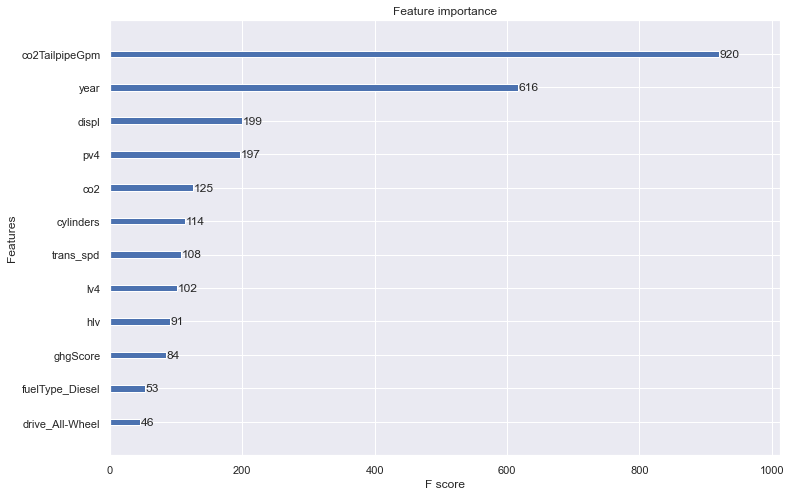

In [39]:
sns.set()
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(fitted_xgb_model, max_num_features=12, ax=ax,\
                    importance_type="weight")
plt.show()

## Interpreting SHAP Summary and Dependence Plots

### Initializing Explainers

In [40]:
shap_xgb_explainer = shap.TreeExplainer(fitted_xgb_model)

In [41]:
background = X_train.iloc[np.random.choice(X_train.shape[0], 150, replace=False)]
print(background.shape)
shap_nn_explainer = shap.GradientExplainer(fitted_nn_model,\
                                         background.astype(float).values)

(150, 81)


Using plaidml.keras.backend backend.


### Computing SHAP Values

In [42]:
shap_xgb_values_train = shap_xgb_explainer.shap_values(X_train)
print(shap_xgb_values_train.shape)
shap_xgb_values_test = shap_xgb_explainer.shap_values(X_test)
print(shap_xgb_values_test.shape)

(29455, 81)
(6498, 81)


In [43]:
shap_nn_values_test = shap_nn_explainer.shap_values(X_test.astype(float).values)
print(type(shap_nn_values_test))
print(shap_nn_values_test[0].shape)

<class 'list'>
(6498, 81)


### Generating SHAP Summary Plots

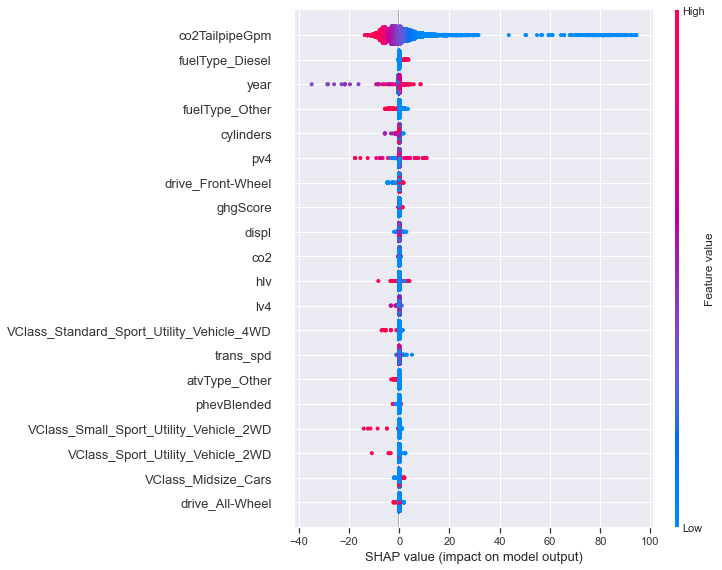

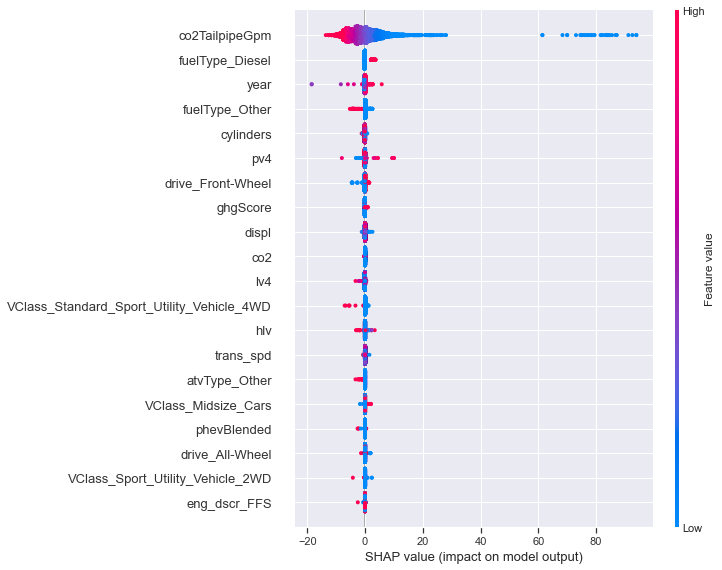

In [44]:
shap.summary_plot(shap_xgb_values_train, X_train, plot_type="dot")
shap.summary_plot(shap_xgb_values_test, X_test, plot_type="dot")

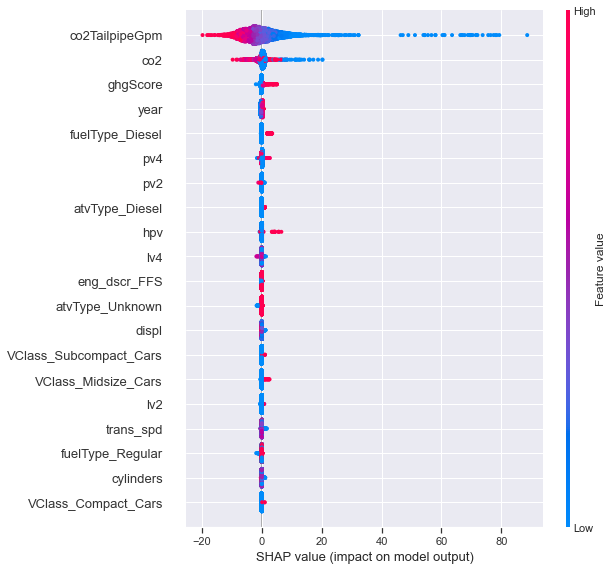

In [45]:
shap.summary_plot(shap_nn_values_test[0], X_test, plot_type="dot")

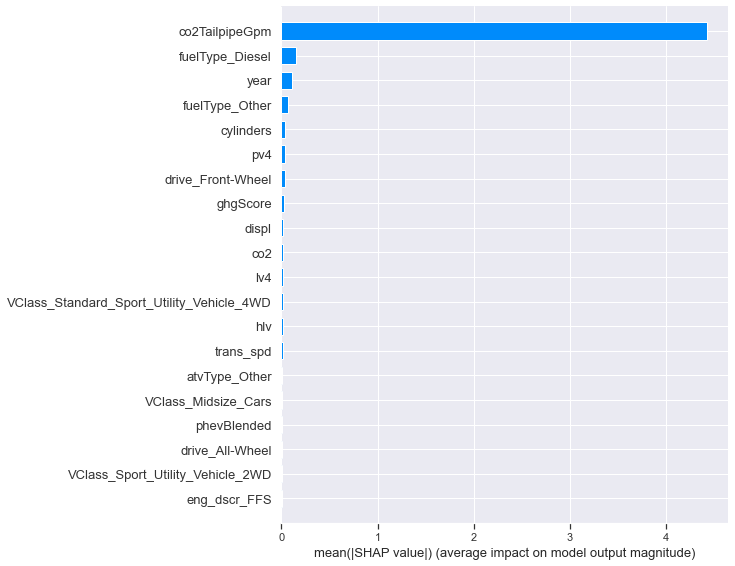

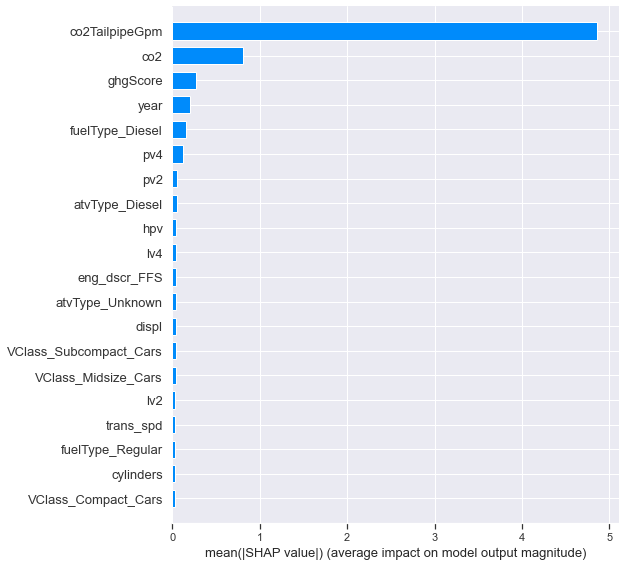

In [46]:
shap.summary_plot(shap_xgb_values_test, X_test, plot_type="bar")
shap.summary_plot(shap_nn_values_test[0], X_test, plot_type="bar")

### Understanding Interactions

In [47]:
top_features_l = ['comb08'] + ['co2TailpipeGpm', 'fuelType_Diesel',\
                               'co2', 'year', 'ghgScore', 'cylinders']
top_df = fueleconomy_df.loc[X_train.index, top_features_l]

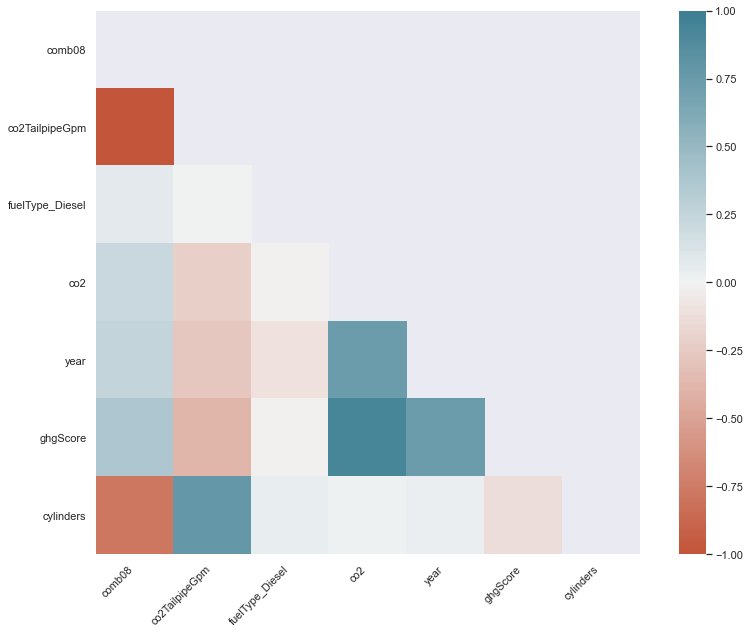

In [48]:
corrs = stats.spearmanr(top_df).correlation
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(
    corrs, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    xticklabels=top_df.columns,
    yticklabels=top_df.columns,
    mask=mask,
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

In [49]:
print('spearman\tco2TailpipeGpm→comb08\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(X_train.co2TailpipeGpm.values, top_df.comb08.values)))
print('point-biserial\tfuelType_Diesel→comb08\tcorr: %.3f\tp-val: %.4f' % 
      (stats.pointbiserialr(top_df.fuelType_Diesel.values, top_df.comb08.values)))
print('spearman\tco2→comb08\t\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(X_train.co2.values, top_df.comb08.values)))
print('spearman\tyear→comb08\t\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(X_train.year.values, top_df.comb08.values)))
print('spearman\tghgScore→comb08\t\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(top_df.ghgScore.values, top_df.comb08.values)))
print('spearman\tcylinders→comb08\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(X_train.cylinders.values, top_df.comb08.values)))

spearman	co2TailpipeGpm→comb08	corr: -0.994	p-val: 0.0000
point-biserial	fuelType_Diesel→comb08	corr: 0.059	p-val: 0.0000
spearman	co2→comb08		corr: 0.220	p-val: 0.0000
spearman	year→comb08		corr: 0.251	p-val: 0.0000
spearman	ghgScore→comb08		corr: 0.371	p-val: 0.0000
spearman	cylinders→comb08	corr: -0.783	p-val: 0.0000


### SHAP Dependence Plots

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


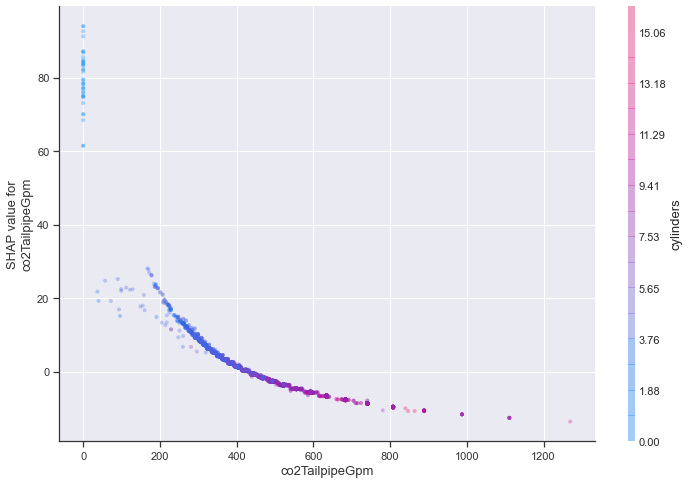

spearman	cylinders→co2TailpipeGpm	corr: 0.789	p-val: 0.0000


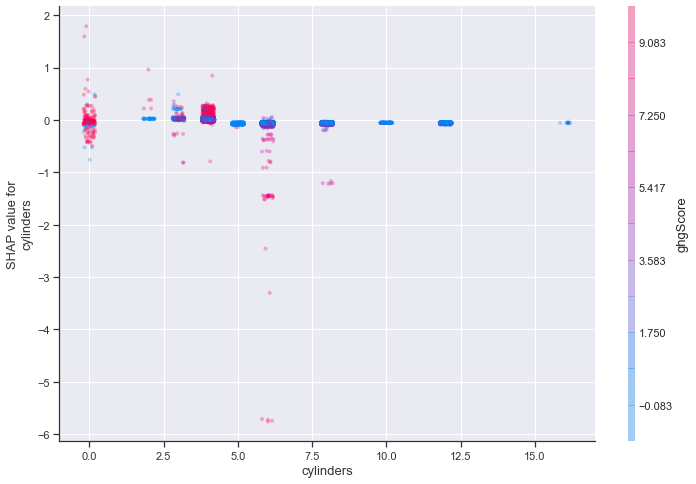

spearman	ghgScore→cylinders		corr: -0.123	p-val: 0.0000


In [50]:
shap.dependence_plot("co2TailpipeGpm", shap_xgb_values_test, X_test,\
                     interaction_index="cylinders", show=False, alpha=0.3)
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()
print('spearman\tcylinders→co2TailpipeGpm\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(X_train.cylinders.values, X_train.co2TailpipeGpm.values)))
shap.dependence_plot("cylinders", shap_xgb_values_train, X_train,\
                     interaction_index="ghgScore", show=False,\
                     x_jitter=0.4, alpha=0.3)
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()
print('spearman\tghgScore→cylinders\t\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(top_df.ghgScore.values, top_df.cylinders.values)))

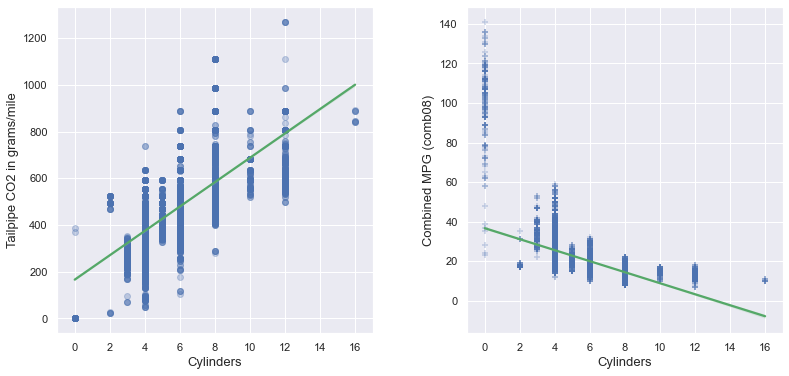

In [51]:
fig, axs = plt.subplots(1, 2, figsize = (13,6))
fig.subplots_adjust(hspace=0, wspace=0.3)
sns.regplot(x=X_train.cylinders, y=X_train.co2TailpipeGpm, ax=axs[0],\
            scatter_kws={'alpha':0.3}, line_kws={'color':'g'})
axs[0].set_ylabel('Tailpipe CO2 in grams/mile', fontsize=13)
axs[0].set_xlabel('Cylinders', fontsize=13)
axs[0].set_xlim([-1,17])
sns.regplot(x=X_train.cylinders, y=y_train, ax=axs[1], marker="+",\
            scatter_kws={'alpha':0.3}, line_kws={'color':'g'})
axs[1].set_ylabel('Combined MPG (comb08)', fontsize=13)
axs[1].set_xlabel('Cylinders', fontsize=13)
axs[1].set_xlim([-1,17])
plt.show() 

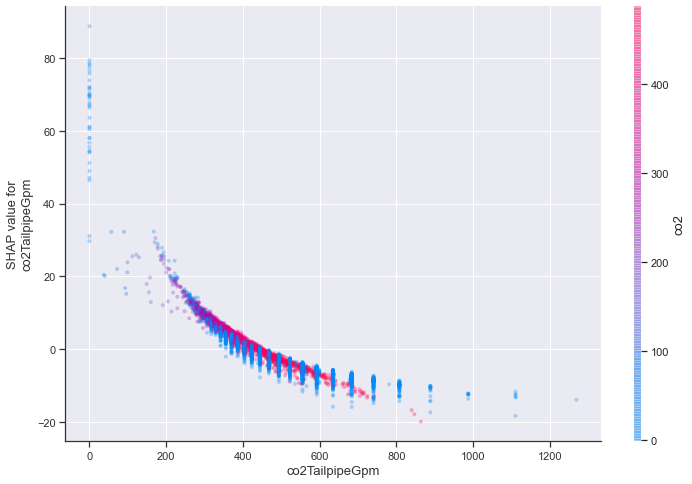

spearman	co2→co2TailpipeGpm	corr: -0.224	p-val: 0.0000


In [52]:
shap.dependence_plot("co2TailpipeGpm", shap_nn_values_test[0],\
                     X_test, alpha=0.3,\
                     interaction_index="co2", show=False)
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()
print('spearman\tco2→co2TailpipeGpm\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(X_train.co2.values, X_train.co2TailpipeGpm.values)))

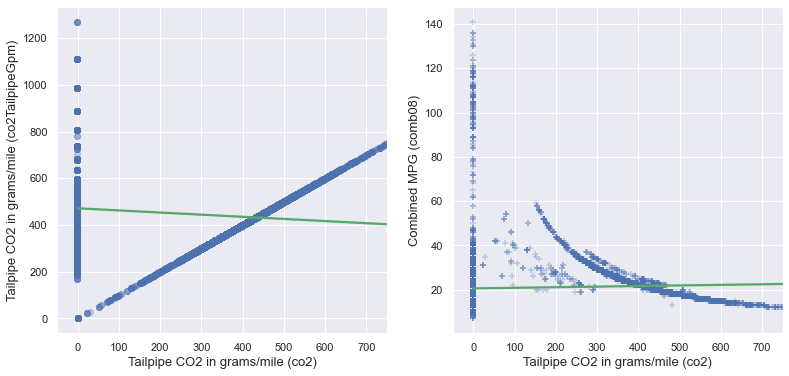

In [53]:
fig, axs = plt.subplots(1, 2, figsize = (13,6))
sns.regplot(x=X_train.co2, y=X_train.co2TailpipeGpm, ax=axs[0],\
            scatter_kws={'alpha':0.3}, line_kws={'color':'g'})
axs[0].set_ylabel('Tailpipe CO2 in grams/mile (co2TailpipeGpm)',\
                  fontsize=13)
axs[0].set_xlabel('Tailpipe CO2 in grams/mile (co2)', fontsize=13)
axs[0].set_xlim([-50, 750])
sns.regplot(x=X_train.co2, y=y_train, ax=axs[1], marker="+",\
            scatter_kws={'alpha':0.3}, line_kws={'color':'g'})
axs[1].set_ylabel('Combined MPG (comb08)', fontsize=13)
axs[1].set_xlabel('Tailpipe CO2 in grams/mile (co2)', fontsize=13)
axs[1].set_xlim([-50, 750])
plt.show() 

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


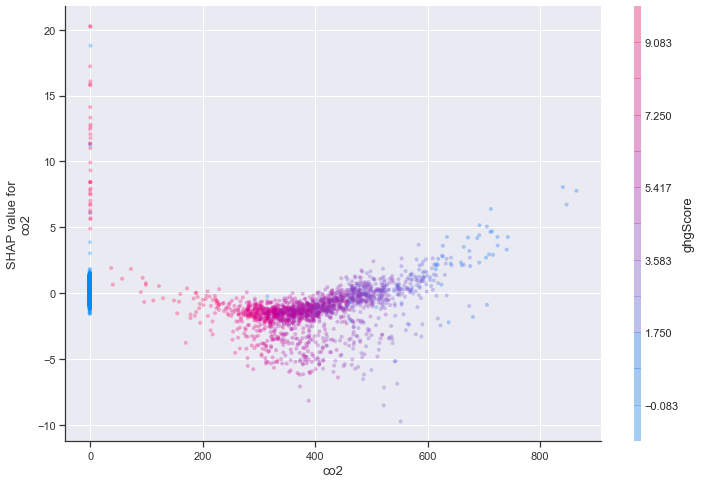

spearman	ghgScore→co2	corr: 0.941	p-val: 0.0000


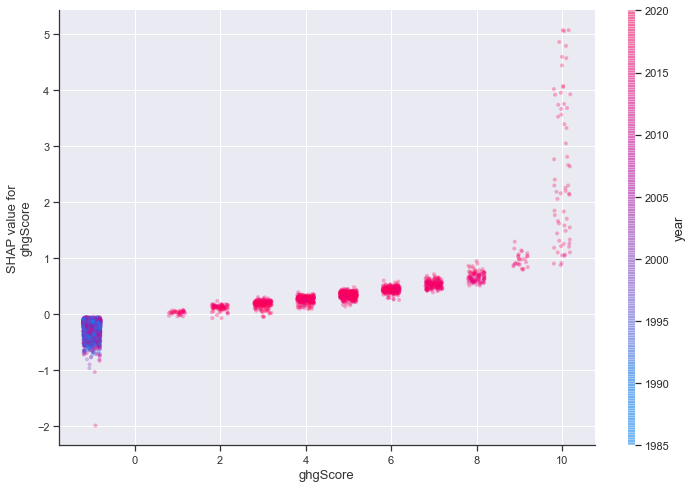

spearman	ghgScore→year	corr: 0.745	p-val: 0.0000


In [54]:
shap.dependence_plot("co2", shap_nn_values_test[0],\
                     X_test, alpha=0.3, x_jitter=10,\
                     interaction_index="ghgScore", show=False)
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()
print('spearman\tghgScore→co2\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(top_df.ghgScore.values, top_df.co2.values)))
shap.dependence_plot("ghgScore", shap_nn_values_test[0],\
                     X_test, alpha=0.3, x_jitter=0.4,\
                     interaction_index="year", show=False)
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()
print('spearman\tghgScore→year\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(top_df.ghgScore.values, top_df.year.values)))

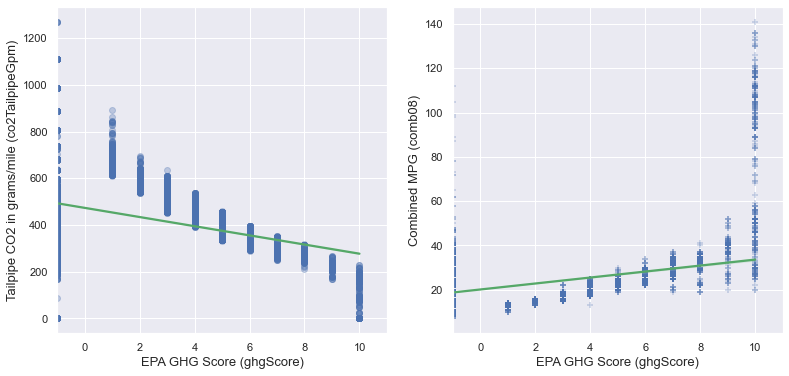

In [55]:
fig, axs = plt.subplots(1, 2, figsize = (13,6))
sns.regplot(x=X_train.ghgScore, y=X_train.co2TailpipeGpm, ax=axs[0],\
            scatter_kws={'alpha':0.3}, line_kws={'color':'g'})
axs[0].set_ylabel('Tailpipe CO2 in grams/mile (co2TailpipeGpm)',\
                  fontsize=13)
axs[0].set_xlabel('EPA GHG Score (ghgScore)', fontsize=13)
axs[0].set_xlim([-1, 11])
sns.regplot(x=X_train.ghgScore, y=y_train, ax=axs[1], marker="+",\
            scatter_kws={'alpha':0.3}, line_kws={'color':'g'})
axs[1].set_ylabel('Combined MPG (comb08)', fontsize=13)
axs[1].set_xlabel('EPA GHG Score (ghgScore)', fontsize=13)
axs[1].set_xlim([-1, 11])
plt.show() 

### SHAP Force Plots

In [56]:
sample_test_size = 0.05
sample_test_idx = np.random.choice(X_test.shape[0],
                                   math.ceil(X_test.shape[0]*sample_test_size),\
                                   replace=False)
shap.initjs()
shap.force_plot(shap_xgb_explainer.expected_value,\
                shap_xgb_values_test[sample_test_idx],\
                X_test.iloc[sample_test_idx])

## Accumulated Local Effects (ALE) Plots

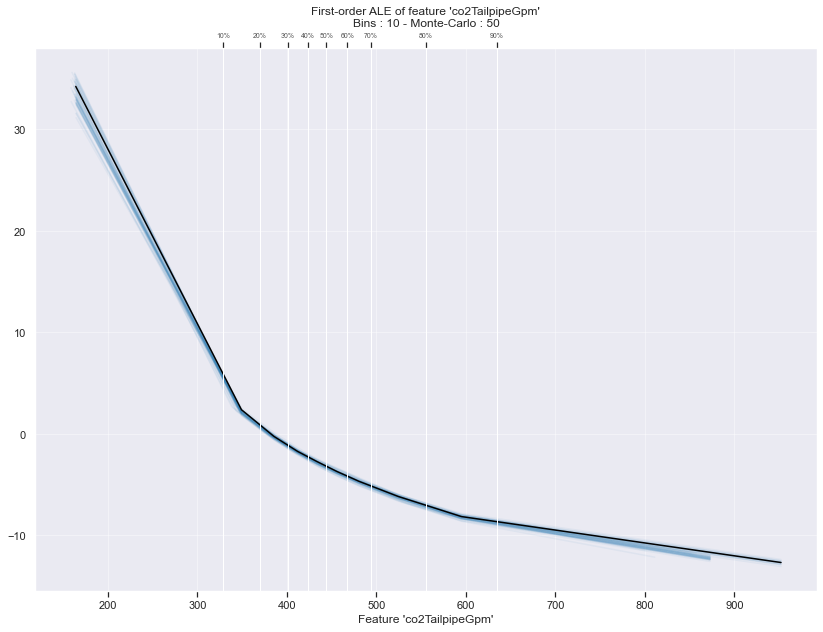

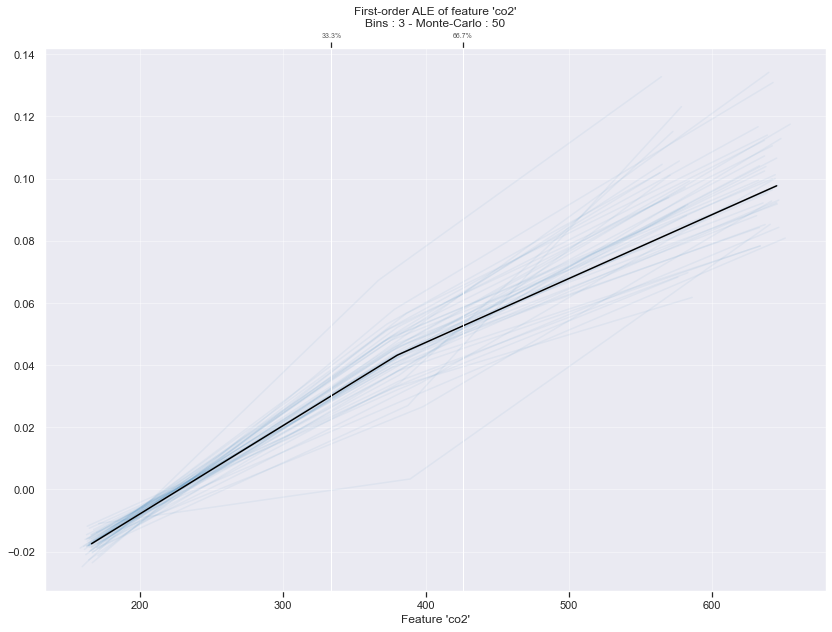

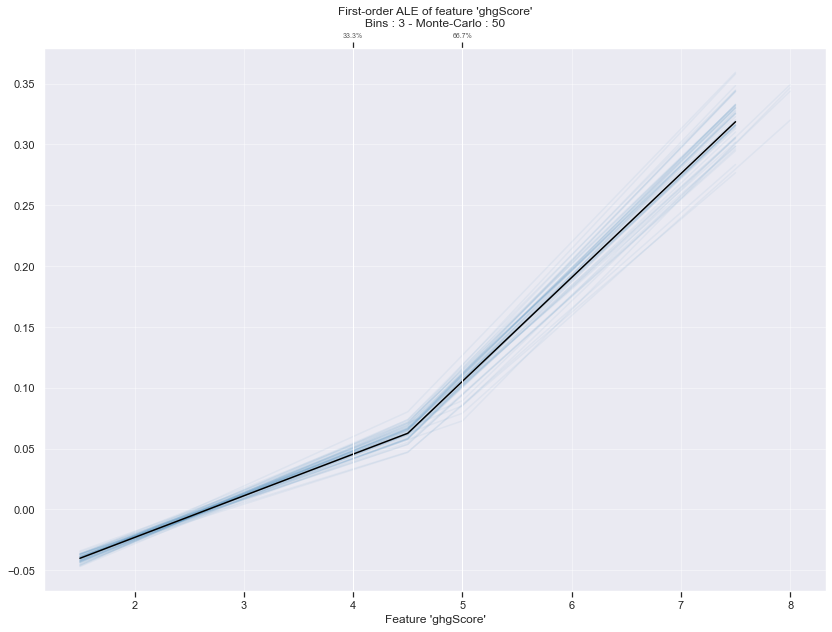

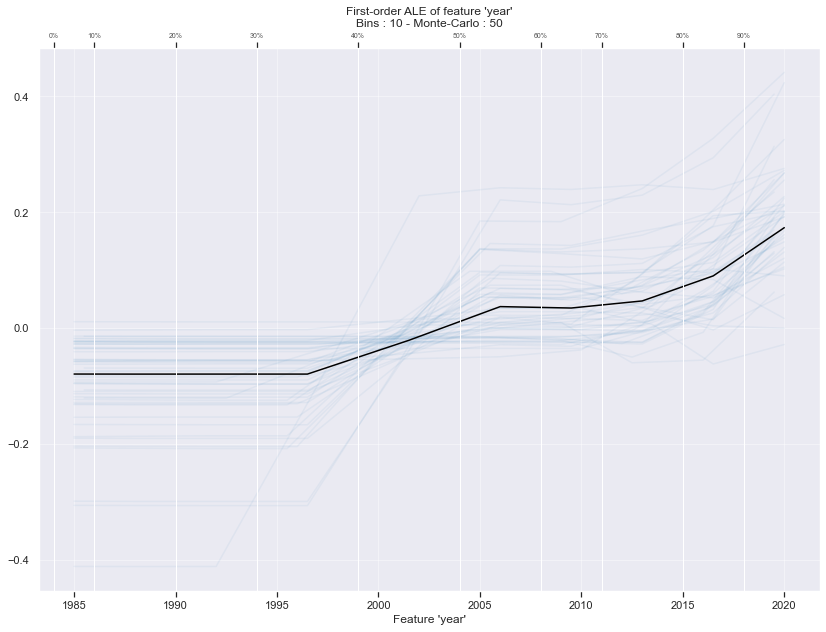

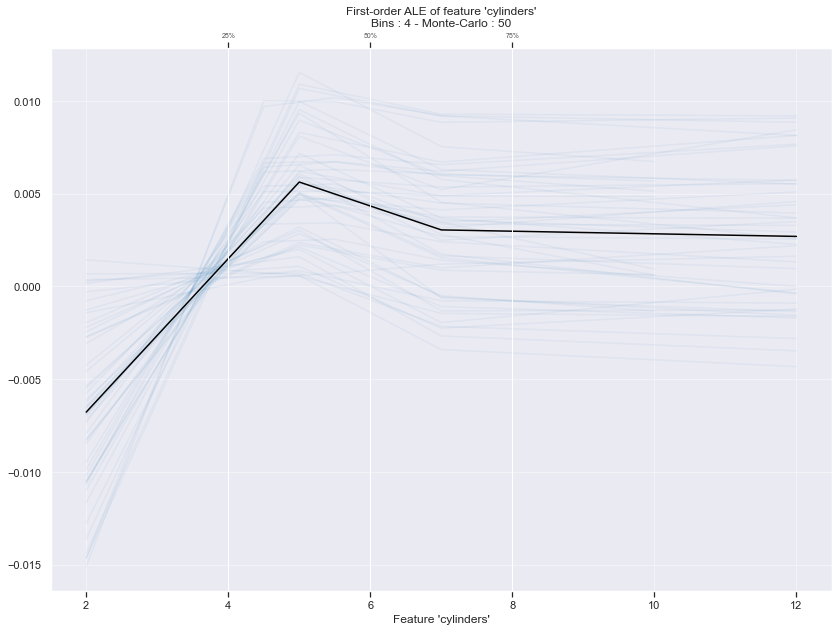

CPU times: user 6min 49s, sys: 829 ms, total: 6min 50s
Wall time: 6min 25s


In [57]:
for feature_name in ['co2TailpipeGpm', 'co2', 'ghgScore',\
                     'year', 'cylinders']:
    plt.rc("figure", figsize=(14, 10))
    ale_plot(
        fitted_xgb_model, X_test, [feature_name], bins=10,\
        monte_carlo=True, monte_carlo_rep=50,\
        monte_carlo_ratio=0.4
    )
    plt.show()

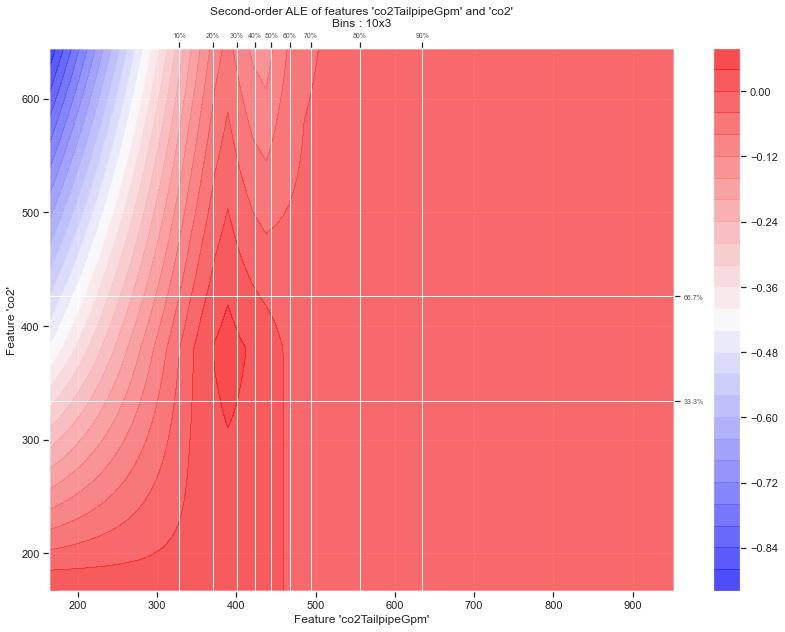

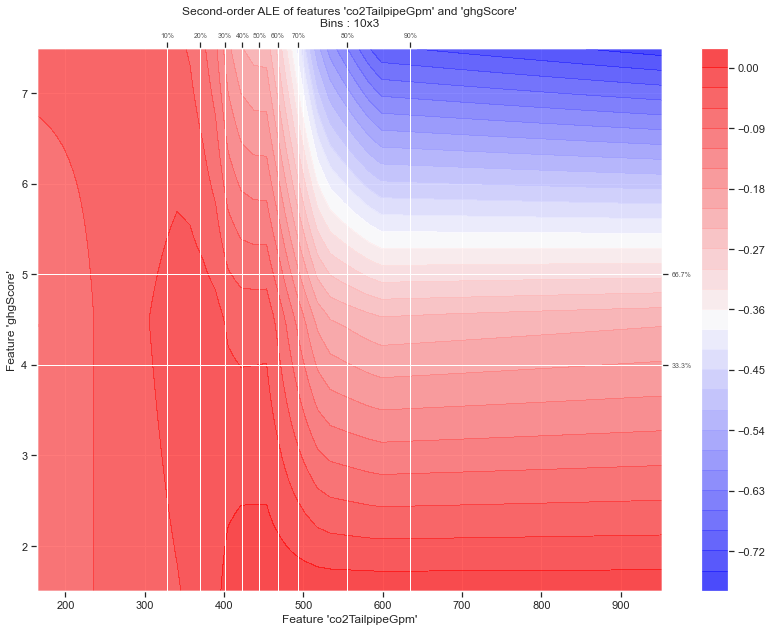

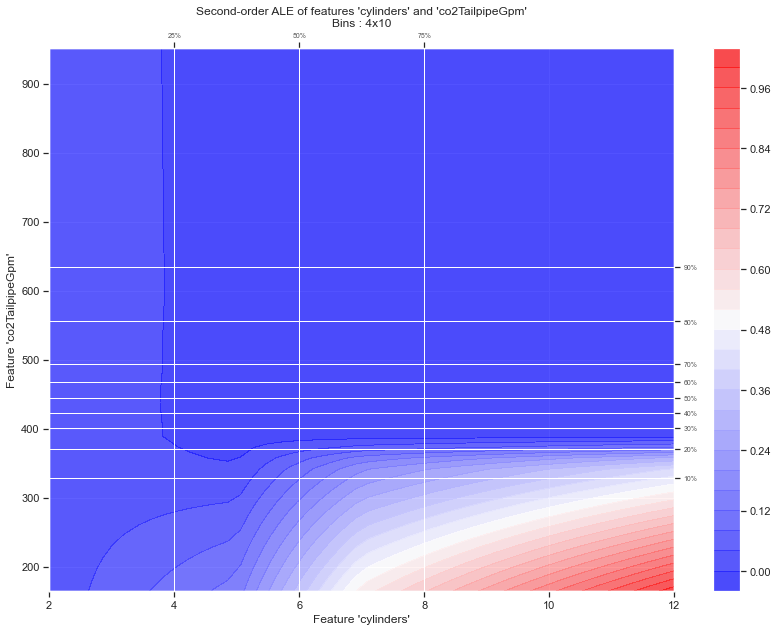

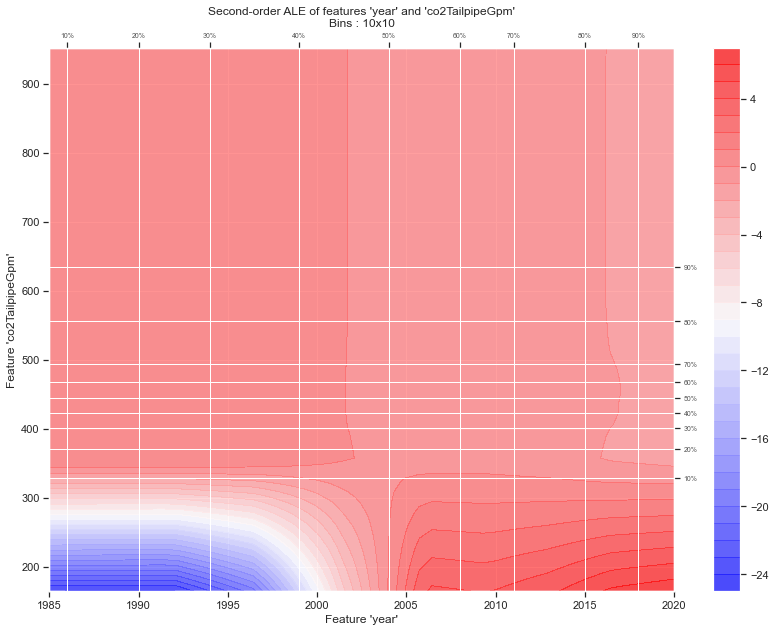

In [58]:
for interaction in [['co2TailpipeGpm', 'co2'], ['co2TailpipeGpm', 'ghgScore'],\
                    ['cylinders', 'co2TailpipeGpm'], ['year', 'co2TailpipeGpm']]:
    plt.rc("figure", figsize=(14, 10))
    ale_plot(
        fitted_xgb_model, X_test, interaction, bins=[10,10]
    )
    plt.show()

## Global Surrogates

### Fitting Surrogates

In [59]:
fitted_dt_surrogate = tree.DecisionTreeRegressor(max_depth=7,\
                                                 random_state=rand).\
                                        fit(X_train, y_train_nn_pred)
y_train_dt_pred = fitted_dt_surrogate.predict(X_train)
y_test_dt_pred = fitted_dt_surrogate.predict(X_test)

In [60]:
fitted_rf_surrogate = RuleFit(max_rules=150, rfmode='regress',\
                              random_state=rand, tree_size=8).\
                        fit(X_train.astype(float).values,\
                            np.array(y_train_nn_pred).squeeze(),\
                            X_train.columns)
y_train_rf_pred = fitted_rf_surrogate.predict(X_train.astype(float).values)
y_test_rf_pred = fitted_rf_surrogate.predict(X_test.astype(float).values)

### Evaluating Surrogates

In [61]:
#Measure how well Decision Tree replicates Neural Network's predictions
RMSE_dt_nn_train = metrics.mean_squared_error(y_train_nn_pred,\
                                              y_train_dt_pred,\
                                              squared=False)
RMSE_dt_nn_test = metrics.mean_squared_error(y_test_nn_pred,\
                                             y_test_dt_pred,\
                                             squared=False)
R2_dt_nn_test = metrics.r2_score(y_test_nn_pred, y_test_dt_pred)
#Print all metrics
print('RMSE_train: %.4f\tRMSE_test: %.4f\tr2: %.4f' %\
                (RMSE_dt_nn_train, RMSE_dt_nn_test, R2_dt_nn_test))

RMSE_train: 0.4805	RMSE_test: 0.6100	r2: 0.9944


In [62]:
#Measure how well Rule Fit replicates Neural Network's predictions
RMSE_rf_nn_train = metrics.mean_squared_error(y_train_nn_pred,\
                                              y_train_rf_pred,\
                                              squared=False)
RMSE_rf_nn_test = metrics.mean_squared_error(y_test_nn_pred,\
                                             y_test_rf_pred,\
                                             squared=False)
R2_rf_nn_test = metrics.r2_score(y_test_nn_pred, y_test_rf_pred)
#Print all metrics
print('RMSE_train: %.4f\tRMSE_test: %.4f\tr2: %.4f' %\
                (RMSE_rf_nn_train, RMSE_rf_nn_test, R2_rf_nn_test))

RMSE_train: 0.9150	RMSE_test: 0.9049	r2: 0.9877


### Interpreting Surrogates

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


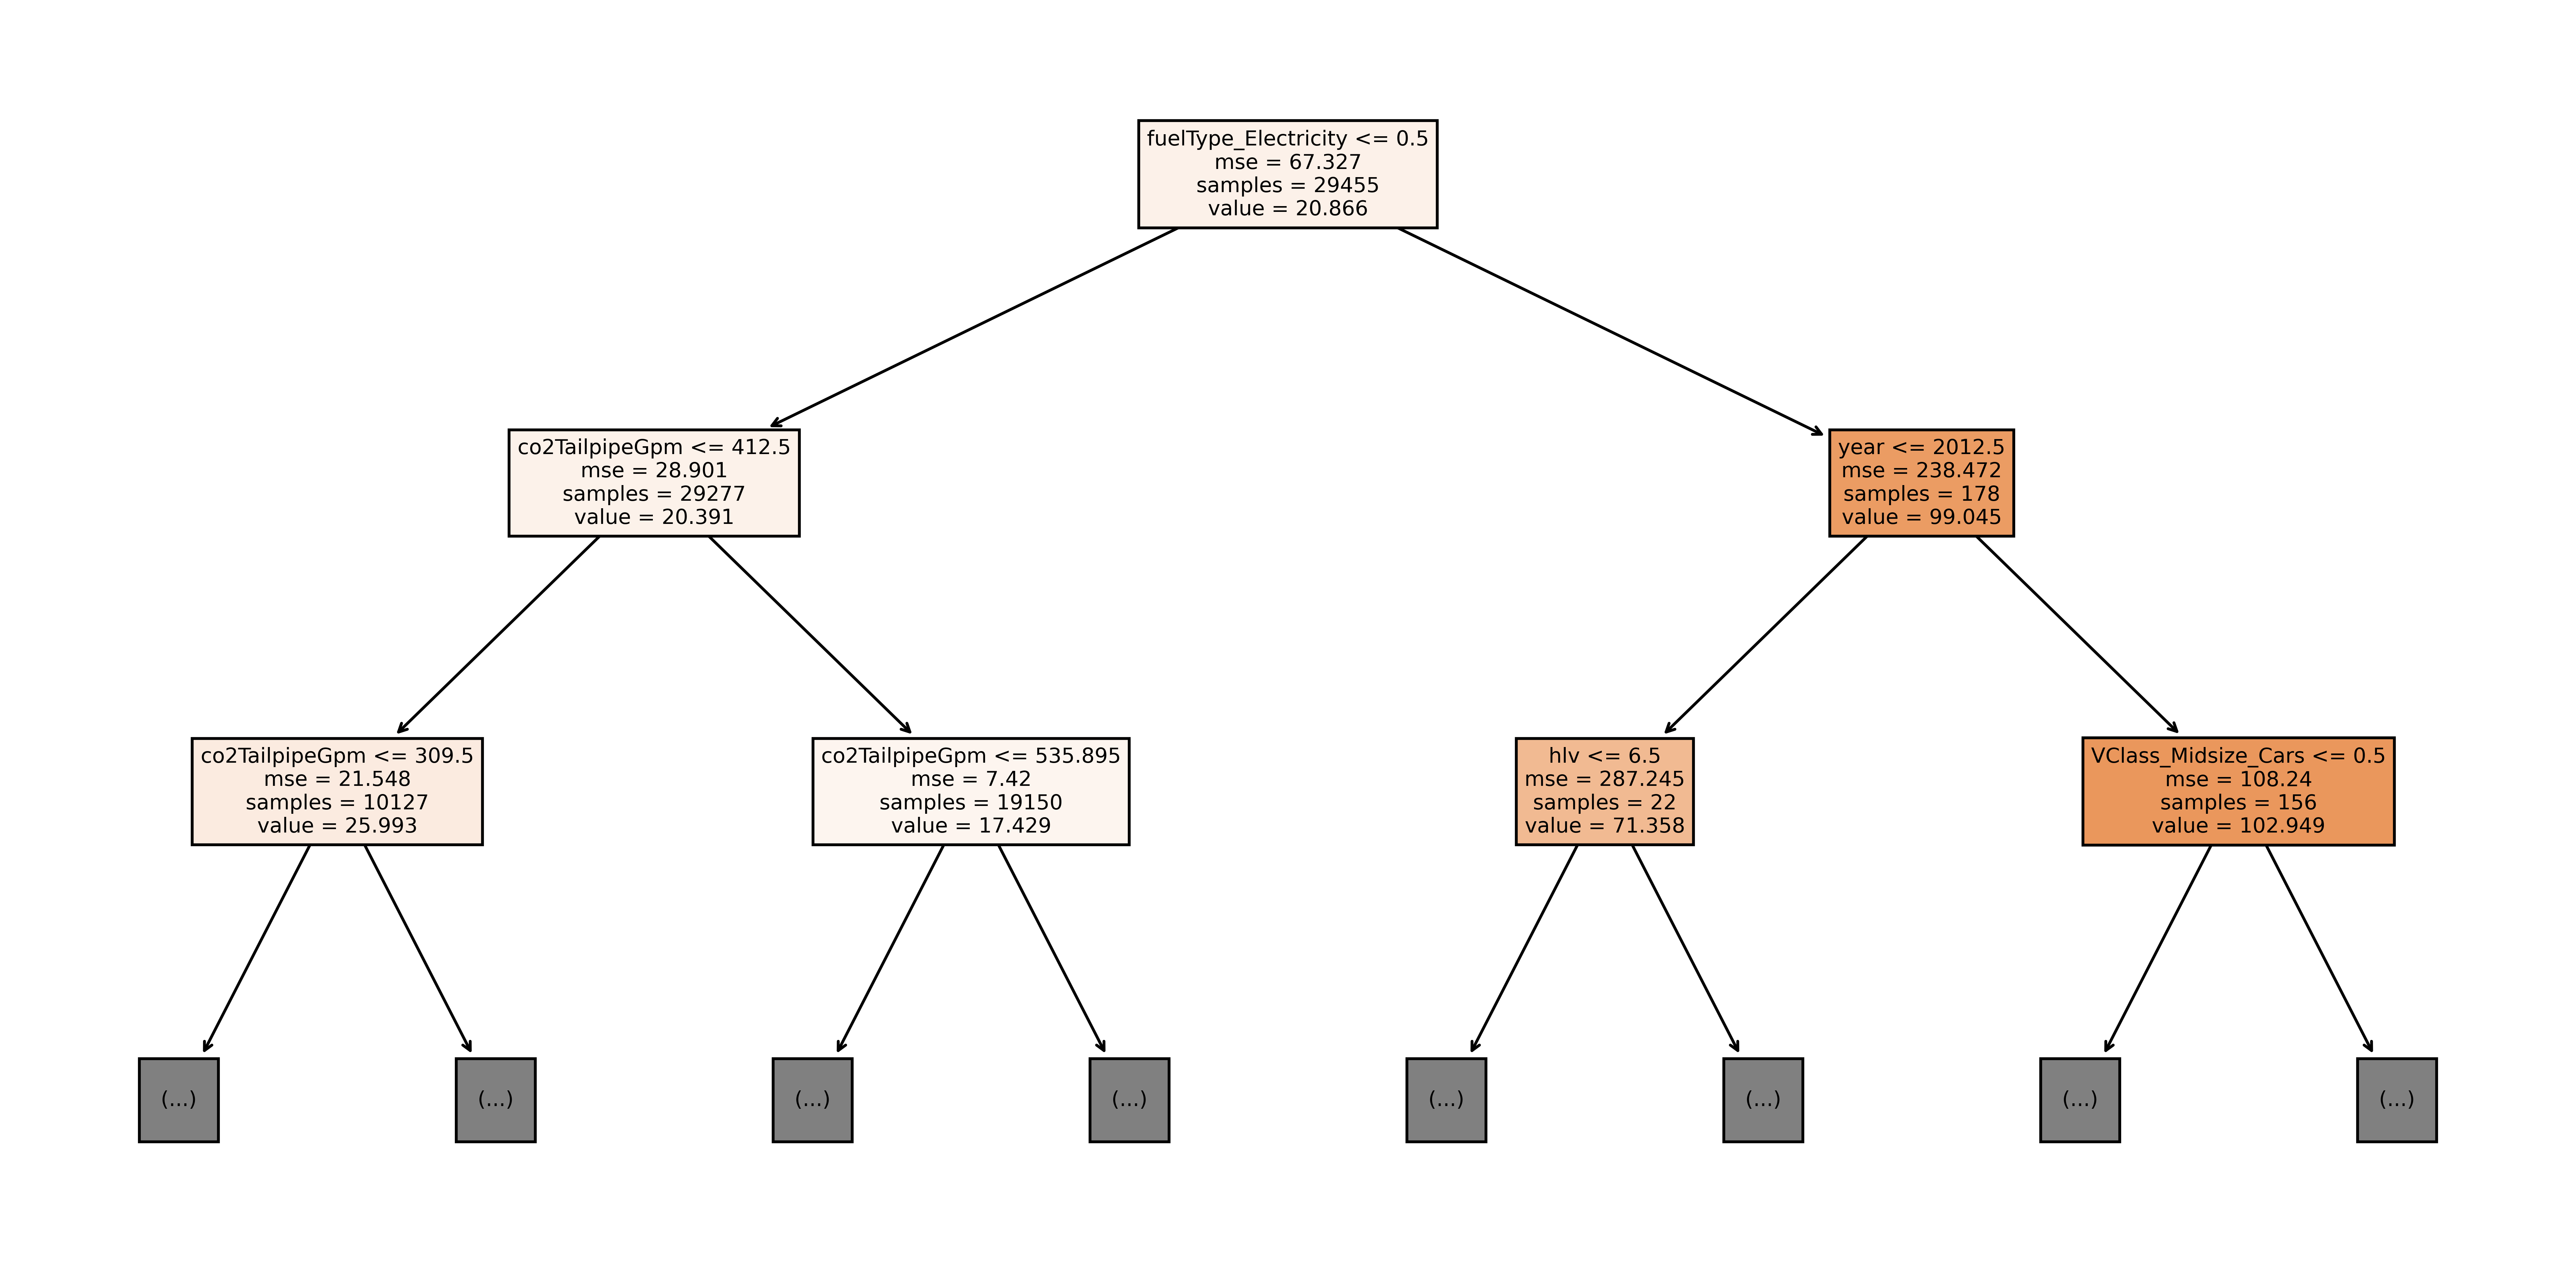

In [63]:
sns.reset_orig()
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16,8), dpi=600)
tree.plot_tree(fitted_dt_surrogate,\
               feature_names=X_train.columns.values.tolist(), filled = True, max_depth=2)
fig.show()

In [64]:
text_tree = tree.export_text(fitted_dt_surrogate,\
               feature_names=X_train.columns.values.tolist())
print(text_tree)

|--- fuelType_Electricity <= 0.50
|   |--- co2TailpipeGpm <= 412.50
|   |   |--- co2TailpipeGpm <= 309.50
|   |   |   |--- co2TailpipeGpm <= 234.43
|   |   |   |   |--- drive_Front-Wheel <= 0.50
|   |   |   |   |   |--- atvType_Other <= 0.50
|   |   |   |   |   |   |--- co2TailpipeGpm <= 197.88
|   |   |   |   |   |   |   |--- value: [49.54]
|   |   |   |   |   |   |--- co2TailpipeGpm >  197.88
|   |   |   |   |   |   |   |--- value: [40.34]
|   |   |   |   |   |--- atvType_Other >  0.50
|   |   |   |   |   |   |--- co2TailpipeGpm <= 165.50
|   |   |   |   |   |   |   |--- value: [32.85]
|   |   |   |   |   |   |--- co2TailpipeGpm >  165.50
|   |   |   |   |   |   |   |--- value: [29.28]
|   |   |   |   |--- drive_Front-Wheel >  0.50
|   |   |   |   |   |--- co2TailpipeGpm <= 194.50
|   |   |   |   |   |   |--- hlv <= 19.50
|   |   |   |   |   |   |   |--- value: [46.85]
|   |   |   |   |   |   |--- hlv >  19.50
|   |   |   |   |   |   |   |--- value: [53.64]
|   |   |   |   |   |--- c

In [65]:
rulefit_df = fitted_rf_surrogate.get_rules()
rulefit_df = rulefit_df[rulefit_df.coef != 0]
rulefit_df.sort_values(by="importance", ascending=False)

rule    type       coef  \
4                                       co2TailpipeGpm  linear  -0.032542   
132                                   atvType_EV > 0.5    rule  24.897840   
88                         displ > 0.30000001192092896    rule -14.924096   
167                 cylinders <= 1.0 & ghgScore <= 4.5    rule -17.959679   
14                                     fuelType_Diesel  linear   3.624268   
..                                                 ...     ...        ...   
38                         VClass_Small_Station_Wagons  linear   0.034334   
64                                   eng_dscr_CA_model  linear   0.013023   
26                                    drive_Rear-Wheel  linear   0.009481   
177  co2TailpipeGpm <= 86.0 & co2TailpipeGpm <= 377...    rule   0.015664   
92   co2TailpipeGpm <= 535.8947448730469 & co2Tailp...    rule  -0.000027   

      support  importance  
4    1.000000    3.663626  
132  0.008857    2.332828  
88   0.992914    1.251820  
167  0.001771    0.755234  
14   1.000000    0.596587  
..        ...         ...  
38   1.000000    0.006595  
64   1.000000    0.006403  
26   1.000000    0.004467  
177  0.003543    0.000931  
92   0.325066    0.000013  

[89 rows x 5 columns]